# K-nearest Neighbor for Winner Prediction

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import svm #Import svm model
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

## KNN on PvP Dataset

In [3]:
# Load the data
data = pd.read_csv('../1D_All_ReplaysData_PvP.csv')  # Replace with your actual file path

# Assuming combined_data is your DataFrame
data = data.drop(data[data['Winner'] == 0].index)
# Assuming df is your DataFrame and 'ReplayID' is the column to be encoded
label_encoder = LabelEncoder()
data['ReplayID_encoded'] = label_encoder.fit_transform(data['ReplayID'])
# data['Winner'] = label_encoder.fit_transform(data['Winner'])
data['MapName_encoded'] = label_encoder.fit_transform(data['MapName'])

# last_rows = data.groupby('ReplayID').tail(70).groupby('ReplayID').head(1)

# Calculate the 80th percentile of the 'Frame' column within each group of 'ReplayID'
percentile_80_grouped = data.groupby('ReplayID')['Frame'].quantile(0.8)

# Define a function to find the row with the closest 'Frame' value to the 80th percentile within each group
def find_nearest_row(group):
    nearest_index = (group['Frame'] - percentile_80_grouped[group.name]).abs().idxmin()
    return group.loc[[nearest_index]]

# Apply the function to each group of 'ReplayID' and concatenate the results
nearest_rows = data.groupby('ReplayID', group_keys=False).apply(find_nearest_row)

# Reset the index if needed
nearest_rows.reset_index(drop=True, inplace=True)


In [4]:
nearest_rows

,ReplayID,Duration,Frame,MapName,MapWidth,MapHeight,Player1_EAPM,Player1_ECmdCount,Player1_Race,Player2_EAPM,...,Player2_Protoss Ground Armor_Level,Player2_Protoss Ground Weapons_Level,Player2_Protoss Plasma Shields_Level,Player2_Reaver Capacity_Level,Player2_Scarab Damage_Level,Player2_Sensor Array_Level,Player2_Singularity Charge_Level,Winner,ReplayID_encoded,MapName_encoded
0,GG10,20568,16400,Blade Storm,128,128,140,2001,Protoss,105,...,0,1,0,0,0,0,1,2,0,80
1,GG10042,28603,22800,| iCCup | PeaksOfBeakdu,96,128,168,3360,Protoss,187,...,1,1,0,0,0,0,1,2,1,163
2,GG10043,34851,27800,| iCCup | Paranoid Android,96,96,182,4434,Protoss,171,...,1,1,0,0,0,0,1,2,2,162
3,GG10056,37973,30300,WCG Gaia 1.1,128,128,148,3896,Protoss,169,...,2,3,0,0,0,0,1,1,3,70
4,GG1010,38455,30700,Gauntlet2003,128,96,166,4463,Protoss,151,...,2,1,1,0,0,0,1,2,4,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,TL89,30124,24000,The Lost Temple_Gamei,128,128,180,3800,Protoss,21,...,0,0,0,0,0,0,0,1,359,106
360,TL900,53788,43000,Desert FoX,128,128,187,7027,Protoss,171,...,0,0,1,0,0,0,0,1,360,82
361,TL937,34624,27600,신 백두대간 2.4,96,128,216,5225,Protoss,223,...,1,3,0,0,0,0,0,2,361,41
362,TL959,49197,39300,Rush Hour Ⅲ,128,128,151,5181,Protoss,120,...,0,0,0,0,0,0,1,1,362,65


In [5]:
# Define features (X) and target variable (y)
X = nearest_rows.drop(['ReplayID', 'Winner','Player1_Race', 'Player2_Race', 'MapName'], axis=1)
y = nearest_rows['Winner']

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42) # 70% training and 30% test

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled  = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)
X_scaled = scaler.transform(X)

In [16]:
#Create a svm Classifier
ml = KNeighborsClassifier()

#Train the model using the training sets
ml.fit(X_train_scaled, y_train)

#Predict the response for test dataset
y_pred = ml.predict(X_test_scaled)

In [17]:
# Model Accuracy
ml.score(X_test_scaled,y_test)

0.6545454545454545

In [18]:
confusion_matrix(y_test,y_pred)

array([[32, 19],
       [19, 40]], dtype=int64)

# Grid Search CV for hyperpaarameter tuning

In [19]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_neighbors": list(range(1, 20,2)),
    "weights": ["uniform", "distance"],
}

knn = KNeighborsClassifier(n_jobs=-1)

clf = RandomizedSearchCV(knn, param_grid, n_jobs=-1, n_iter=3, verbose=2, cv=3)

clf.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=-1), n_iter=3,
                   n_jobs=-1,
                   param_distributions={'n_neighbors': [1, 3, 5, 7, 9, 11, 13,
                                                        15, 17, 19],
                                        'weights': ['uniform', 'distance']},
                   verbose=2)

In [20]:
knn = clf.best_estimator_

In [21]:
knn.score(X_test_scaled, y_test)

0.7272727272727273

## KNN on Full Dataset

In [3]:
data = pd.read_csv('../Processed Datasets/StarCraft_Combined_Dataset.csv')  

# Assuming combined_data is your DataFrame
data = data.drop(data[data['Winner'] == 0].index)
# Assuming df is your DataFrame and 'ReplayID' is the column to be encoded
label_encoder = LabelEncoder()
label_encoders = {}

for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName','Winner']:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Calculate the 80th percentile of the 'Frame' column within each group of 'ReplayID'
percentile_80_grouped = data.groupby('ReplayID')['Frame'].quantile(0.8)

# Define a function to find the row with the closest 'Frame' value to the 80th percentile within each group
def find_nearest_row(group):
    nearest_index = (group['Frame'] - percentile_80_grouped[group.name]).abs().idxmin()
    return group.loc[[nearest_index]]

# Apply the function to each group of 'ReplayID' and concatenate the results
nearest_rows = data.groupby('ReplayID', group_keys=False).apply(find_nearest_row)

# Reset the index if needed
nearest_rows.reset_index(drop=True, inplace=True)


In [4]:
# Define features (X) and target variable (y)
X = nearest_rows.drop(['ReplayID', 'Winner','Player1_Race', 'Player2_Race', 'MapName'], axis=1)
y = nearest_rows['Winner']

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42) # 70% training and 30% test

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled  = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)
X_scaled = scaler.transform(X)

In [7]:
#Create a svm Classifier
ml = KNeighborsClassifier()

#Train the model using the training sets
ml.fit(X_train_scaled, y_train)

#Predict the response for test dataset
y_pred = ml.predict(X_test_scaled)

In [8]:
# Model Accuracy
ml.score(X_test_scaled,y_test)

0.6795774647887324

In [9]:
confusion_matrix(y_test,y_pred)

array([[259, 141],
       [132, 320]], dtype=int64)

# Grid Search CV for hyperpaarameter tuning

In [26]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_neighbors": list(range(1, 30,2)),
    "weights": ["uniform", "distance"],
}

knn = KNeighborsClassifier(n_jobs=-1)

clf = RandomizedSearchCV(knn, param_grid, n_jobs=-1, n_iter=30, verbose=2, cv=3)

clf.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=-1), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'n_neighbors': [1, 3, 5, 7, 9, 11, 13,
                                                        15, 17, 19, 21, 23, 25,
                                                        27, 29],
                                        'weights': ['uniform', 'distance']},
                   verbose=2)

In [27]:
knn = clf.best_estimator_

In [28]:
knn

KNeighborsClassifier(n_jobs=-1, n_neighbors=13, weights='distance')

In [24]:
knn.score(X_test_scaled, y_test)

0.6643192488262911

### All stages accuracy comparison

0.1
Accuracy: 0.61
0.2
Accuracy: 0.58
0.3
Accuracy: 0.58
0.4
Accuracy: 0.56
0.5
Accuracy: 0.57
0.6
Accuracy: 0.59
0.7
Accuracy: 0.62
0.8
Accuracy: 0.68
0.9
Accuracy: 0.70
1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.74


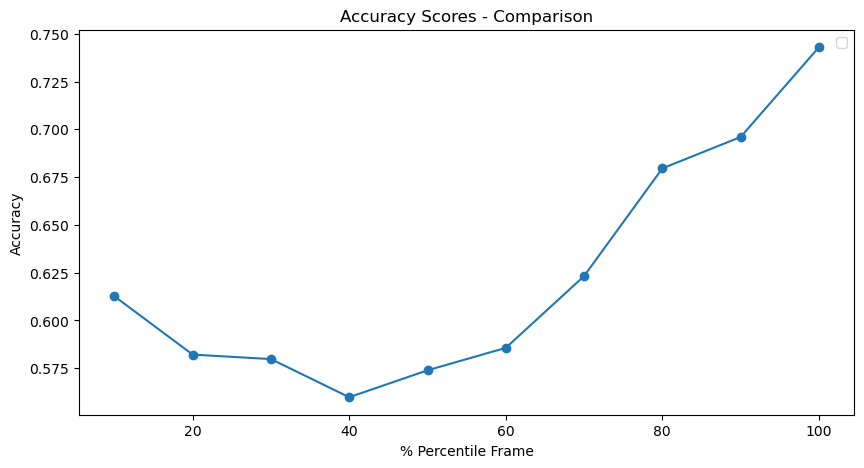

In [25]:
data = pd.read_csv('../Processed Datasets/StarCraft_Combined_Dataset.csv')  

# Assuming combined_data is your DataFrame
data = data.drop(data[data['Winner'] == 0].index)
# Assuming df is your DataFrame and 'ReplayID' is the column to be encoded
label_encoder = LabelEncoder()
label_encoders = {}

for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName','Winner']:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

def calculate_for_per2(per):
    # Calculate the 80th percentile of the 'Frame' column within each group of 'ReplayID'
    percentile_80_grouped = data.groupby('ReplayID')['Frame'].quantile(per)

    # Define a function to find the row with the closest 'Frame' value to the 80th percentile within each group
    def find_nearest_row(group):
        nearest_index = (group['Frame'] - percentile_80_grouped[group.name]).abs().idxmin()
        return group.loc[[nearest_index]]

    # Apply the function to each group of 'ReplayID' and concatenate the results
    nearest_rows = data.groupby('ReplayID', group_keys=False).apply(find_nearest_row)

    # Reset the index if needed
    nearest_rows.reset_index(drop=True, inplace=True)

    # Define features (X) and target variable (y)
    X = nearest_rows.drop(['ReplayID', 'Winner','Player1_Race', 'Player2_Race', 'MapName'], axis=1)
    y = nearest_rows['Winner']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42) # 70% training and 30% test
    scaler = StandardScaler()

    X_train_scaled  = scaler.fit_transform(x_train)
    X_test_scaled = scaler.transform(x_test)
    # X_scaled = scaler.transform(X)
    #Create a svm Classifier
    ml = KNeighborsClassifier()

    #Train the model using the training sets
    ml.fit(X_train_scaled, y_train)

    #Predict the response for test dataset
    y_pred = ml.predict(X_test_scaled)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Return cross-validation scores
    return accuracy


plt.figure(figsize=(10, 5))
temp = []
for i in range(10, 110, 10):
    print(i / 100)
    temp.append(calculate_for_per2(i / 100))

plt.plot(range(10, 110, 10),temp, marker='o', linestyle='-')
    
plt.xlabel('% Percentile Frame')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores - Comparison')
plt.legend()
plt.show()
